# Hybrid CRND-L: Cross-Representation Neighborhood Dissonance with Ecological Niche Overlap

**What this demo does:**

This notebook demonstrates the **Cross-Representation Neighborhood Dissonance (CRND)** method for detecting noisy labels in clinical text datasets. It:

1. **Builds 3 feature spaces** from text data: TF-IDF, sentence embeddings (all-MiniLM-L6-v2), and character n-gram features
2. **Computes CRND scores** measuring how much k-NN neighborhoods disagree across representations
3. **Evaluates 4 hybrid formulations** (H1-H4) combining CRND with label-based signals
4. **Runs noise injection experiments** at multiple rates with ROC-AUC/Spearman/Precision@K metrics
5. **Performs ecological niche overlap** analysis (Schoener's D) and 4-quadrant subpopulation analysis
6. **Compares against 6 baselines**: kDN, cleanlab, WANN-adapted, cartography proxy, random, and hybrid variants

**Dataset:** Medical abstracts (60 stratified examples across 5 clinical categories)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# sentence-transformers — NOT on Colab, always install
_pip('sentence-transformers==3.4.1')

# Core packages — pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scikit-learn==1.6.1', 'scipy==1.16.3', 'matplotlib==3.10.0')
    # Install CPU-only torch (Colab has GPU torch pre-installed)
    _pip('torch==2.9.0+cpu', '--extra-index-url', 'https://download.pytorch.org/whl/cpu')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import gc
import json
import os
import re
import time
import warnings
from pathlib import Path
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde, kendalltau, kruskal, rankdata, spearmanr
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

## Data Loading

Load the mini demo dataset (60 medical abstracts across 5 clinical categories). The data is loaded from GitHub with a local fallback.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter5_hybrid_crnd_l_e/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()

# Extract first dataset
ds_entry = data["datasets"][0]
ds_name = ds_entry["dataset"]
examples = ds_entry["examples"]
texts = [ex["input"] for ex in examples]
labels = [str(ex["output"]) for ex in examples]

print(f"Dataset: {ds_name}")
print(f"Examples: {len(texts)}")
print(f"Labels: {sorted(set(labels))}")
print(f"Sample text (first 200 chars): {texts[0][:200]}...")

Dataset: medical_abstracts
Examples: 60
Labels: ['Cardiovascular_diseases', 'Digestive_system_diseases', 'General_pathological_conditions', 'Neoplasms', 'Nervous_system_diseases']
Sample text (first 200 chars): Recent changes in the treatment of aortoiliac occlusive disease by the Oxford Regional Vascular Service. Over the four years from 1 January 1985 to 31 December 1988, 192 patients were treated for aort...


## Configuration

All tunable parameters. Adjust these to trade off between runtime and result quality.

In [5]:
# --- Config: adjust these to trade runtime vs quality ---
# All parameters set to original production values

K_NEIGHBORS = 10          # Original: 10
NOISE_RATES = [0.05, 0.10, 0.20]  # Original: [0.05, 0.10, 0.20]
N_SEEDS = 3               # Original: 3
N_BOOTSTRAP = 1000        # Original: 1000
N_CARTO_ROUNDS = 5        # Original: 5
N_CV_SPLITS = 5           # Original: 5
EMBED_BATCH_SIZE = 64     # Original: 64
CHAR_NGRAM_VECTOR_SIZE = 100  # Original: 100

## Phase 0: Data Preparation

Encode labels and prepare for feature space construction.

In [6]:
t_start = time.time()

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
unique_classes = list(range(len(le.classes_)))

print(f"Classes ({len(le.classes_)}): {le.classes_.tolist()}")
print(f"Label distribution: {dict(zip(le.classes_, np.bincount(labels_encoded)))}")

Classes (5): ['Cardiovascular_diseases', 'Digestive_system_diseases', 'General_pathological_conditions', 'Neoplasms', 'Nervous_system_diseases']
Label distribution: {np.str_('Cardiovascular_diseases'): np.int64(12), np.str_('Digestive_system_diseases'): np.int64(12), np.str_('General_pathological_conditions'): np.int64(12), np.str_('Neoplasms'): np.int64(12), np.str_('Nervous_system_diseases'): np.int64(12)}


## Phase 1: Feature Space Construction

Build three distinct feature representations:
1. **TF-IDF** (word n-grams) — lexical features
2. **Sentence Embeddings** (all-MiniLM-L6-v2) — semantic features  
3. **Character N-grams** (char_wb 3-5) with PCA — surface-level features

In [7]:
def build_tfidf_features(texts: list[str]) -> np.ndarray:
    """TF-IDF with clinical preprocessing, max 5000 features."""
    max_feats = min(5000, max(100, len(texts) * 2))
    vectorizer = TfidfVectorizer(
        max_features=max_feats,
        stop_words="english",
        min_df=max(2, int(len(texts) * 0.005)),
        max_df=0.95,
        sublinear_tf=True,
        ngram_range=(1, 2),
    )
    X = vectorizer.fit_transform(texts).toarray()
    print(f"TF-IDF shape: {X.shape}")
    return X


def build_sentence_embeddings(texts: list[str], batch_size: int = EMBED_BATCH_SIZE) -> np.ndarray:
    """all-MiniLM-L6-v2 sentence embeddings, 384-dim. CPU-only."""
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=False)
    print(f"Sentence embeddings shape: {embeddings.shape}")
    return embeddings


def build_doc2vec_features(texts: list[str], vector_size: int = CHAR_NGRAM_VECTOR_SIZE) -> np.ndarray:
    """Char n-gram TF-IDF features with PCA dimensionality reduction."""
    vectorizer = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3, 5),
        max_features=min(3000, max(100, len(texts) * 2)),
        min_df=max(2, int(len(texts) * 0.005)),
        max_df=0.95,
        sublinear_tf=True,
    )
    X = vectorizer.fit_transform(texts).toarray()
    # Cap PCA components at min(vector_size, n_samples, n_features)
    n_components = min(vector_size, X.shape[0], X.shape[1])
    if X.shape[1] > n_components:
        pca = PCA(n_components=n_components, random_state=42)
        X = pca.fit_transform(X)
    print(f"Char n-gram features shape: {X.shape}")
    return X


# Build all three feature spaces
print("Building TF-IDF features...")
X_tfidf = build_tfidf_features(texts)

print("Building sentence embeddings...")
X_embed = build_sentence_embeddings(texts)

print("Building char n-gram features...")
X_chargram = build_doc2vec_features(texts)

print(f"\nFeature space construction completed in {time.time() - t_start:.1f}s")

Building TF-IDF features...
TF-IDF shape: (60, 120)
Building sentence embeddings...


Sentence embeddings shape: (60, 384)
Building char n-gram features...


Char n-gram features shape: (60, 60)

Feature space construction completed in 17.7s


## Phase 2: Score Computation

Compute CRND (Cross-Representation Neighborhood Dissonance) and baseline scores:
- **CRND**: Measures disagreement of k-NN neighborhoods across feature spaces (Jaccard-based)
- **kDN**: k-Disagreeing Neighbors (fraction of neighbors with different label)
- **Cleanlab**: Self-confidence via cross-validated predicted probabilities
- **WANN-adapted**: Distance-weighted k-NN label agreement
- **Cartography proxy**: Variability/confidence from multiple CV rounds

In [8]:
def jaccard_index(set_a: set, set_b: set) -> float:
    """Jaccard similarity: |A n B| / |A u B|."""
    if not set_a and not set_b:
        return 1.0
    return len(set_a & set_b) / len(set_a | set_b)


def compute_crnd(
    X_space1: np.ndarray,
    X_space2: np.ndarray,
    X_space3: np.ndarray,
    k: int = K_NEIGHBORS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Cross-Representation Neighborhood Dissonance."""
    effective_k = min(k, X_space1.shape[0] - 1)
    if effective_k < 1:
        N = X_space1.shape[0]
        return np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

    nn1 = NearestNeighbors(n_neighbors=effective_k + 1, metric="cosine").fit(X_space1)
    nn2 = NearestNeighbors(n_neighbors=effective_k + 1, metric="cosine").fit(X_space2)
    nn3 = NearestNeighbors(n_neighbors=effective_k + 1, metric="cosine").fit(X_space3)

    _, idx1 = nn1.kneighbors(X_space1)
    _, idx2 = nn2.kneighbors(X_space2)
    _, idx3 = nn3.kneighbors(X_space3)

    idx1 = idx1[:, 1:]
    idx2 = idx2[:, 1:]
    idx3 = idx3[:, 1:]

    N = X_space1.shape[0]
    crnd = np.zeros(N)
    pair_12 = np.zeros(N)
    pair_13 = np.zeros(N)
    pair_23 = np.zeros(N)

    for i in range(N):
        s_12 = jaccard_index(set(idx1[i]), set(idx2[i]))
        s_13 = jaccard_index(set(idx1[i]), set(idx3[i]))
        s_23 = jaccard_index(set(idx2[i]), set(idx3[i]))

        pair_12[i] = 1.0 - s_12
        pair_13[i] = 1.0 - s_13
        pair_23[i] = 1.0 - s_23
        crnd[i] = 1.0 - np.mean([s_12, s_13, s_23])

    return crnd, pair_12, pair_13, pair_23


def compute_kdn(X: np.ndarray, labels: np.ndarray, k: int = K_NEIGHBORS) -> np.ndarray:
    """k-Disagreeing Neighbors: fraction of k-NN with different label."""
    effective_k = min(k, X.shape[0] - 1)
    if effective_k < 1:
        return np.zeros(len(labels))

    nn = NearestNeighbors(n_neighbors=effective_k + 1, metric="cosine").fit(X)
    _, indices = nn.kneighbors(X)
    indices = indices[:, 1:]

    labels_arr = np.asarray(labels)
    kdn = np.zeros(len(labels))
    for i in range(len(labels)):
        neighbor_labels = labels_arr[indices[i]]
        kdn[i] = np.mean(neighbor_labels != labels_arr[i])
    return kdn


def compute_cleanlab_scores(
    X: np.ndarray,
    labels_encoded: np.ndarray,
    n_splits: int = N_CV_SPLITS,
) -> np.ndarray:
    """Cleanlab self-confidence scores via cross-validated predicted probabilities."""
    n_classes = len(np.unique(labels_encoded))
    actual_splits = min(n_splits, min(np.bincount(labels_encoded)))
    actual_splits = max(2, actual_splits)

    clf = LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs", multi_class="multinomial")
    cv = StratifiedKFold(n_splits=actual_splits, shuffle=True, random_state=42)

    try:
        pred_probs = cross_val_predict(clf, X, labels_encoded, cv=cv, method="predict_proba")
    except ValueError:
        return np.full(len(labels_encoded), 0.5)

    self_conf = np.array(
        [pred_probs[i, labels_encoded[i]] for i in range(len(labels_encoded))]
    )
    return 1.0 - self_conf


def compute_wann_adapted(
    X_embed: np.ndarray,
    labels_encoded: np.ndarray,
    k: int = K_NEIGHBORS,
) -> np.ndarray:
    """WANN-adapted: distance-weighted k-NN label agreement in embedding space."""
    effective_k = min(k, X_embed.shape[0] - 1)
    if effective_k < 1:
        return np.zeros(len(labels_encoded))

    nn = NearestNeighbors(n_neighbors=effective_k + 1, metric="cosine").fit(X_embed)
    distances, indices = nn.kneighbors(X_embed)
    distances = distances[:, 1:]
    indices = indices[:, 1:]

    distances = np.maximum(distances, 1e-10)
    weights = 1.0 / distances

    labels_arr = np.asarray(labels_encoded)
    wann_scores = np.zeros(len(labels_encoded))

    for i in range(len(labels_encoded)):
        neighbor_labels = labels_arr[indices[i]]
        same_label = (neighbor_labels == labels_arr[i]).astype(float)
        weighted_agreement = np.sum(same_label * weights[i]) / np.sum(weights[i])
        wann_scores[i] = 1.0 - weighted_agreement

    return wann_scores


def compute_cartography_proxy(
    X: np.ndarray,
    labels_encoded: np.ndarray,
    n_rounds: int = N_CARTO_ROUNDS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Dataset Cartography proxy using multiple random-seed CV rounds."""
    N = len(labels_encoded)
    min_class_count = min(np.bincount(labels_encoded))
    n_folds = min(N_CV_SPLITS, min_class_count)
    n_folds = max(2, n_folds)

    all_probs = np.zeros((N, n_rounds))

    for seed_idx in range(n_rounds):
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42 + seed_idx)
        clf = LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs", multi_class="multinomial")
        try:
            pred_probs = cross_val_predict(
                clf, X, labels_encoded, cv=cv, method="predict_proba"
            )
            for i in range(N):
                all_probs[i, seed_idx] = pred_probs[i, labels_encoded[i]]
        except ValueError:
            all_probs[:, seed_idx] = 0.5

    confidence = np.mean(all_probs, axis=1)
    variability = np.std(all_probs, axis=1)
    cartography_score = variability / (confidence + 1e-8)

    return cartography_score, confidence, variability


def compute_label_entropy(
    X_space1: np.ndarray,
    X_space2: np.ndarray,
    X_space3: np.ndarray,
    labels_encoded: np.ndarray,
    k: int = K_NEIGHBORS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Average kDN across 3 feature spaces."""
    kdn1 = compute_kdn(X_space1, labels_encoded, k)
    kdn2 = compute_kdn(X_space2, labels_encoded, k)
    kdn3 = compute_kdn(X_space3, labels_encoded, k)
    label_entropy = (kdn1 + kdn2 + kdn3) / 3.0
    return label_entropy, kdn1, kdn2, kdn3


# Compute all scores
print("Computing CRND scores...")
crnd, pair_te, pair_tl, pair_el = compute_crnd(X_tfidf, X_embed, X_chargram)

print("Computing label entropy (kDN per space)...")
label_entropy, kdn_tfidf, kdn_embed, kdn_llm = compute_label_entropy(
    X_tfidf, X_embed, X_chargram, labels_encoded
)
kdn_avg = (kdn_tfidf + kdn_embed + kdn_llm) / 3.0

print("Computing cleanlab scores...")
cleanlab_tfidf = compute_cleanlab_scores(X_tfidf, labels_encoded)
cleanlab_embed = compute_cleanlab_scores(X_embed, labels_encoded)
cleanlab_avg = (cleanlab_tfidf + cleanlab_embed) / 2.0

print("Computing WANN-adapted scores...")
wann = compute_wann_adapted(X_embed, labels_encoded)

print("Computing cartography proxy scores...")
carto_score, carto_conf, carto_var = compute_cartography_proxy(X_tfidf, labels_encoded)

print(f"\nScore computation completed in {time.time() - t_start:.1f}s")
print(f"CRND: mean={np.mean(crnd):.3f}, std={np.std(crnd):.3f}")
print(f"kDN avg: mean={np.mean(kdn_avg):.3f}, std={np.std(kdn_avg):.3f}")

Computing CRND scores...
Computing label entropy (kDN per space)...
Computing cleanlab scores...


Computing WANN-adapted scores...
Computing cartography proxy scores...



Score computation completed in 19.4s
CRND: mean=0.826, std=0.057
kDN avg: mean=0.760, std=0.095


## Phase 3: Hybrid CRND-L Formulations

Four hybrid formulations combining structural (CRND) and label-based signals:
- **H1**: CRND × label_entropy (multiplicative)
- **H2**: CRND × kDN_avg (multiplicative)
- **H3**: rank(CRND) + rank(kDN) (rank fusion)
- **H4**: CRND_tfidf_vs_chargram × kDN_avg (best pair)

In [9]:
def compute_hybrid_scores(
    crnd: np.ndarray,
    pair_12: np.ndarray,
    pair_13: np.ndarray,
    pair_23: np.ndarray,
    kdn_avg: np.ndarray,
    label_entropy: np.ndarray,
) -> dict[str, np.ndarray]:
    """Six hybrid formulations (H1-H4)."""
    N = len(crnd)
    h1 = crnd * label_entropy
    h2 = crnd * kdn_avg

    rank_crnd = rankdata(crnd) / N
    rank_kdn = rankdata(kdn_avg) / N
    h3 = rank_crnd + rank_kdn

    h4 = pair_13 * kdn_avg  # space1 (tfidf) vs space3 (chargram)

    return {"H1": h1, "H2": h2, "H3": h3, "H4": h4}


print("Computing hybrid scores (H1-H4)...")
hybrids = compute_hybrid_scores(crnd, pair_te, pair_tl, pair_el, kdn_avg, label_entropy)

for name, scores in hybrids.items():
    print(f"  {name}: mean={np.mean(scores):.4f}, std={np.std(scores):.4f}")

Computing hybrid scores (H1-H4)...
  H1: mean=0.6283, std=0.0936
  H2: mean=0.6283, std=0.0936
  H3: mean=1.0167, std=0.4257
  H4: mean=0.6238, std=0.1108


## Phase 4: Noise Injection & Evaluation

Inject label noise at configurable rates, then evaluate all methods (CRND, hybrids, baselines) on detecting which labels were flipped. Metrics: ROC-AUC, Spearman correlation, Precision@K.

In [10]:
def inject_noise(
    labels_encoded: np.ndarray,
    noise_rate: float,
    seed: int,
) -> tuple[np.ndarray, np.ndarray]:
    """Flip noise_rate fraction of labels to random different class."""
    rng = np.random.RandomState(seed)
    N = len(labels_encoded)
    n_flip = int(N * noise_rate)
    if n_flip == 0:
        return labels_encoded.copy(), np.zeros(N, dtype=bool)

    flip_indices = rng.choice(N, size=n_flip, replace=False)
    n_classes = len(np.unique(labels_encoded))

    noisy_labels = labels_encoded.copy()
    is_flipped = np.zeros(N, dtype=bool)

    for idx in flip_indices:
        old_label = noisy_labels[idx]
        candidates = [c for c in range(n_classes) if c != old_label]
        if candidates:
            noisy_labels[idx] = rng.choice(candidates)
        is_flipped[idx] = True

    return noisy_labels, is_flipped


def evaluate_noise_detection(
    scores: np.ndarray,
    is_flipped: np.ndarray,
) -> dict[str, float]:
    """Compute ROC-AUC, Spearman rho, Precision@K for noise detection scores."""
    flipped_int = is_flipped.astype(int)

    try:
        if len(np.unique(flipped_int)) < 2:
            auc = 0.5
        else:
            auc = roc_auc_score(flipped_int, scores)
    except ValueError:
        auc = 0.5

    try:
        rho, p_val = spearmanr(scores, flipped_int.astype(float))
        if np.isnan(rho):
            rho, p_val = 0.0, 1.0
    except Exception:
        rho, p_val = 0.0, 1.0

    K = is_flipped.sum()
    if K > 0:
        top_k_indices = np.argsort(scores)[-K:]
        precision_at_k = float(is_flipped[top_k_indices].mean())
    else:
        precision_at_k = 0.0

    return {
        "roc_auc": float(auc),
        "spearman_rho": float(rho),
        "spearman_p": float(p_val),
        "precision_at_k": float(precision_at_k),
    }


def aggregate_seed_results(
    seed_results: list[dict[str, dict[str, float]]],
) -> dict[str, dict[str, float]]:
    """Aggregate metric dictionaries across seeds: mean +/- std."""
    if not seed_results:
        return {}
    method_names = list(seed_results[0].keys())
    agg: dict[str, dict[str, float]] = {}
    for method in method_names:
        metrics_across_seeds: dict[str, list[float]] = {}
        for sr in seed_results:
            if method not in sr:
                continue
            for metric_name, val in sr[method].items():
                metrics_across_seeds.setdefault(metric_name, []).append(val)
        agg[method] = {}
        for metric_name, vals in metrics_across_seeds.items():
            agg[method][f"{metric_name}_mean"] = float(np.mean(vals))
            agg[method][f"{metric_name}_std"] = float(np.std(vals))
    return agg


# Run noise injection evaluation
N_sub = len(labels_encoded)
print("Running noise injection evaluation...")
noise_results: dict[str, Any] = {}

for noise_rate in NOISE_RATES:
    seed_results_list: list[dict[str, dict[str, float]]] = []

    for seed in range(N_SEEDS):
        noise_seed = seed * 100 + int(noise_rate * 100)
        noisy_labels, is_flipped = inject_noise(labels_encoded, noise_rate, seed=noise_seed)

        if is_flipped.sum() == 0:
            continue

        methods: dict[str, np.ndarray] = {
            "crnd": crnd,
            "kdn_tfidf": kdn_tfidf,
            "kdn_embed": kdn_embed,
            "kdn_llm": kdn_llm,
            "kdn_avg": kdn_avg,
            "cleanlab_tfidf": cleanlab_tfidf,
            "cleanlab_embed": cleanlab_embed,
            "cleanlab_avg": cleanlab_avg,
            "wann_adapted": wann,
            "cartography": carto_score,
            "label_entropy": label_entropy,
            "random": np.random.RandomState(seed).rand(N_sub),
        }
        methods.update(hybrids)

        eval_results: dict[str, dict[str, float]] = {}
        for method_name, scores in methods.items():
            eval_results[method_name] = evaluate_noise_detection(scores, is_flipped)

        seed_results_list.append(eval_results)

    if seed_results_list:
        noise_results[str(noise_rate)] = aggregate_seed_results(seed_results_list)

print(f"Noise evaluation completed for rates: {NOISE_RATES}")

Running noise injection evaluation...


Noise evaluation completed for rates: [0.05, 0.1, 0.2]


## Phase 5: Bootstrap Significance Tests & Quadrant Analysis

- **Paired bootstrap** tests whether hybrid methods significantly outperform baselines
- **4-quadrant analysis** partitions instances by median CRND × median label_entropy:
  - Q1 (low CRND, low entropy): Easy/clean
  - Q2 (high CRND, low entropy): Representation-ambiguous
  - Q3 (low CRND, high entropy): Standard noise
  - Q4 (high CRND, high entropy): Genuinely ambiguous

In [11]:
def paired_bootstrap_test(
    scores_a: np.ndarray,
    scores_b: np.ndarray,
    is_flipped: np.ndarray,
    n_bootstrap: int = N_BOOTSTRAP,
    seed: int = 42,
) -> float:
    """Paired bootstrap significance test for ROC-AUC difference."""
    rng = np.random.RandomState(seed)
    N = len(is_flipped)
    flipped_int = is_flipped.astype(int)

    if len(np.unique(flipped_int)) < 2:
        return 1.0

    try:
        observed_diff = roc_auc_score(flipped_int, scores_a) - roc_auc_score(
            flipped_int, scores_b
        )
    except ValueError:
        return 1.0

    count_ge = 0
    for _ in range(n_bootstrap):
        boot_idx = rng.choice(N, size=N, replace=True)
        try:
            auc_a = roc_auc_score(flipped_int[boot_idx], scores_a[boot_idx])
            auc_b = roc_auc_score(flipped_int[boot_idx], scores_b[boot_idx])
            if (auc_a - auc_b) >= observed_diff:
                count_ge += 1
        except ValueError:
            continue

    return count_ge / max(1, n_bootstrap)


def find_best_method(
    methods: dict[str, np.ndarray],
    is_flipped: np.ndarray,
) -> tuple[str, np.ndarray]:
    """Find the method with highest ROC-AUC."""
    best_name = ""
    best_auc = -1.0
    best_scores = np.zeros(len(is_flipped))

    for name, scores in methods.items():
        try:
            auc = roc_auc_score(is_flipped.astype(int), scores)
        except ValueError:
            auc = 0.5
        if auc > best_auc:
            best_auc = auc
            best_name = name
            best_scores = scores

    return best_name, best_scores


def quadrant_analysis(
    crnd: np.ndarray,
    label_entropy: np.ndarray,
    is_flipped: np.ndarray,
    labels_encoded: np.ndarray,
    texts: list[str],
) -> dict[str, Any]:
    """Partition instances by median CRND x median label_entropy into 4 quadrants."""
    med_crnd = float(np.median(crnd))
    med_entropy = float(np.median(label_entropy))

    quadrants = {
        "Q1_easy": (crnd <= med_crnd) & (label_entropy <= med_entropy),
        "Q2_repr_ambiguous": (crnd > med_crnd) & (label_entropy <= med_entropy),
        "Q3_standard_noise": (crnd <= med_crnd) & (label_entropy > med_entropy),
        "Q4_genuinely_ambiguous": (crnd > med_crnd) & (label_entropy > med_entropy),
    }

    results: dict[str, Any] = {"median_crnd": med_crnd, "median_label_entropy": med_entropy}

    for q_name, mask in quadrants.items():
        q_size = int(mask.sum())
        q_noise_rate = float(is_flipped[mask].mean()) if q_size > 0 else 0.0
        q_text_lengths = [len(texts[i]) for i in range(len(texts)) if mask[i]]

        q_labels = labels_encoded[mask]
        if len(q_labels) > 0:
            unique, counts = np.unique(q_labels, return_counts=True)
            class_dist = {str(int(u)): int(c) for u, c in zip(unique, counts)}
        else:
            class_dist = {}

        results[q_name] = {
            "count": q_size,
            "fraction": float(q_size / len(crnd)) if len(crnd) > 0 else 0.0,
            "noise_rate": q_noise_rate,
            "text_length_mean": float(np.mean(q_text_lengths)) if q_text_lengths else 0.0,
            "text_length_std": float(np.std(q_text_lengths)) if q_text_lengths else 0.0,
            "class_distribution": class_dist,
        }

    return results


# Bootstrap significance tests (at 10% noise, seed 0)
print("Running significance tests...")
_, is_flipped_10 = inject_noise(labels_encoded, 0.10, seed=10)
sig_tests: dict[str, Any] = {}

if is_flipped_10.sum() > 0:
    best_hybrid_name, best_hybrid_scores = find_best_method(hybrids, is_flipped_10)
    sig_tests["best_hybrid"] = best_hybrid_name
    sig_tests["best_hybrid_vs_crnd_p"] = paired_bootstrap_test(
        best_hybrid_scores, crnd, is_flipped_10
    )
    sig_tests["best_hybrid_vs_cleanlab_p"] = paired_bootstrap_test(
        best_hybrid_scores, cleanlab_avg, is_flipped_10
    )
    sig_tests["crnd_vs_kdn_p"] = paired_bootstrap_test(crnd, kdn_avg, is_flipped_10)

print(f"Best hybrid: {sig_tests.get('best_hybrid', 'N/A')}")
for k, v in sig_tests.items():
    if k != "best_hybrid":
        print(f"  {k}: {v:.4f}")

# Quadrant analysis
print("\nRunning quadrant analysis...")
quadrant_results = quadrant_analysis(
    crnd=crnd,
    label_entropy=label_entropy,
    is_flipped=is_flipped_10,
    labels_encoded=labels_encoded,
    texts=texts,
)

for q_name in ["Q1_easy", "Q2_repr_ambiguous", "Q3_standard_noise", "Q4_genuinely_ambiguous"]:
    q = quadrant_results[q_name]
    print(f"  {q_name}: n={q['count']} ({q['fraction']:.1%}), noise_rate={q['noise_rate']:.2f}")

Running significance tests...


Best hybrid: H3
  best_hybrid_vs_crnd_p: 0.5160
  best_hybrid_vs_cleanlab_p: 0.4930
  crnd_vs_kdn_p: 0.4960

Running quadrant analysis...
  Q1_easy: n=19 (31.7%), noise_rate=0.00
  Q2_repr_ambiguous: n=14 (23.3%), noise_rate=0.21
  Q3_standard_noise: n=14 (23.3%), noise_rate=0.07
  Q4_genuinely_ambiguous: n=13 (21.7%), noise_rate=0.15


## Phase 6: Schoener's D Niche Overlap & Per-Class Analysis

Compute pairwise ecological niche overlap (Schoener's D) between classes in each feature space. Also test whether niche overlap predicts classifier confusion (Kendall tau).

In [12]:
def compute_schoeners_d_from_2d(
    X_2d: np.ndarray,
    labels_encoded: np.ndarray,
    class_a: int,
    class_b: int,
    grid_points: np.ndarray,
) -> float:
    """Schoener's D overlap from pre-computed PCA-2D + shared grid."""
    mask_a = labels_encoded == class_a
    mask_b = labels_encoded == class_b

    if mask_a.sum() < 3 or mask_b.sum() < 3:
        return float("nan")

    X_a = X_2d[mask_a].T
    X_b = X_2d[mask_b].T

    try:
        kde_a = gaussian_kde(X_a)
        kde_b = gaussian_kde(X_b)
    except (np.linalg.LinAlgError, ValueError):
        return float("nan")

    z_a = kde_a(grid_points)
    z_b = kde_b(grid_points)

    z_a = z_a / z_a.sum() if z_a.sum() > 0 else z_a
    z_b = z_b / z_b.sum() if z_b.sum() > 0 else z_b

    D = 1.0 - 0.5 * np.sum(np.abs(z_a - z_b))
    return float(D)


def compute_niche_overlap_matrix(
    X: np.ndarray,
    labels_encoded: np.ndarray,
    unique_classes: list[int],
    max_pairs: int = 100,
) -> np.ndarray:
    """Compute pairwise Schoener's D."""
    n_classes = len(unique_classes)
    D_matrix = np.eye(n_classes)

    pca = PCA(n_components=min(2, X.shape[1]), random_state=42)
    X_2d = pca.fit_transform(X)

    n_grid = 80
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min = X_2d[:, 1].min() - 1 if X_2d.shape[1] > 1 else -1
    y_max = X_2d[:, 1].max() + 1 if X_2d.shape[1] > 1 else 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_grid), np.linspace(y_min, y_max, n_grid))
    grid_points = np.vstack([xx.ravel(), yy.ravel()])

    pairs = [(i, j) for i in range(n_classes) for j in range(i + 1, n_classes)]
    if len(pairs) > max_pairs:
        rng = np.random.RandomState(42)
        selected = rng.choice(len(pairs), size=max_pairs, replace=False)
        pairs = [pairs[s] for s in selected]

    for i, j in pairs:
        d_val = compute_schoeners_d_from_2d(
            X_2d, labels_encoded, unique_classes[i], unique_classes[j], grid_points
        )
        D_matrix[i, j] = d_val
        D_matrix[j, i] = d_val

    return D_matrix


def per_class_crnd_analysis(
    crnd: np.ndarray,
    labels_encoded: np.ndarray,
    unique_classes: list[int],
) -> dict[str, Any]:
    """Kruskal-Wallis test + per-class CRND stats."""
    groups = [crnd[labels_encoded == c] for c in unique_classes]
    non_empty = [g for g in groups if len(g) > 0]

    if len(non_empty) < 2:
        stat, p_val = 0.0, 1.0
    else:
        try:
            stat, p_val = kruskal(*non_empty)
        except ValueError:
            stat, p_val = 0.0, 1.0

    per_class: dict[str, Any] = {}
    for c, g in zip(unique_classes, groups):
        if len(g) > 0:
            per_class[str(c)] = {
                "mean": float(np.mean(g)),
                "median": float(np.median(g)),
                "std": float(np.std(g)),
                "n": int(len(g)),
            }
        else:
            per_class[str(c)] = {"mean": 0.0, "median": 0.0, "std": 0.0, "n": 0}

    return {
        "kruskal_wallis_stat": float(stat),
        "kruskal_wallis_p": float(p_val),
        "per_class": per_class,
    }


def niche_predicts_classifier(
    X_space1: np.ndarray,
    X_space2: np.ndarray,
    X_space3: np.ndarray,
    labels_encoded: np.ndarray,
    niche_s1: np.ndarray,
    niche_s2: np.ndarray,
    niche_s3: np.ndarray,
    unique_classes: list[int],
) -> dict[str, Any]:
    """Test whether niche overlap predicts pairwise classification difficulty."""
    n_classes = len(unique_classes)
    if n_classes < 2:
        return {"tau_space1": 0.0, "tau_space2": 0.0, "tau_space3": 0.0}

    results: dict[str, Any] = {}

    for space_name, X, niche_matrix in [
        ("space1_tfidf", X_space1, niche_s1),
        ("space2_embed", X_space2, niche_s2),
        ("space3_llm", X_space3, niche_s3),
    ]:
        n_folds = min(N_CV_SPLITS, min(np.bincount(labels_encoded)))
        n_folds = max(2, n_folds)

        clf = LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs", multi_class="multinomial")
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

        try:
            preds = cross_val_predict(clf, X, labels_encoded, cv=cv)
        except ValueError:
            results[f"tau_{space_name}"] = 0.0
            results[f"p_{space_name}"] = 1.0
            continue

        confusion_rates = []
        niche_overlaps = []

        for i in range(n_classes):
            for j in range(i + 1, n_classes):
                mask_ij = (labels_encoded == unique_classes[i]) | (
                    labels_encoded == unique_classes[j]
                )
                if mask_ij.sum() < 5:
                    continue

                preds_ij = preds[mask_ij]
                labels_ij = labels_encoded[mask_ij]

                n_confused = np.sum(
                    ((labels_ij == unique_classes[i]) & (preds_ij == unique_classes[j]))
                    | ((labels_ij == unique_classes[j]) & (preds_ij == unique_classes[i]))
                )
                conf_rate = n_confused / mask_ij.sum()

                niche_val = niche_matrix[i, j]
                if not np.isnan(niche_val):
                    confusion_rates.append(conf_rate)
                    niche_overlaps.append(niche_val)

        if len(confusion_rates) >= 3:
            try:
                tau, p_val = kendalltau(niche_overlaps, confusion_rates)
                results[f"tau_{space_name}"] = float(tau) if not np.isnan(tau) else 0.0
                results[f"p_{space_name}"] = float(p_val) if not np.isnan(p_val) else 1.0
            except Exception:
                results[f"tau_{space_name}"] = 0.0
                results[f"p_{space_name}"] = 1.0
        else:
            results[f"tau_{space_name}"] = 0.0
            results[f"p_{space_name}"] = 1.0

    return results


# Compute niche overlap matrices
print("Computing Schoener's D niche overlap...")
niche_tfidf = compute_niche_overlap_matrix(X_tfidf, labels_encoded, unique_classes)
niche_embed = compute_niche_overlap_matrix(X_embed, labels_encoded, unique_classes)
niche_chargram = compute_niche_overlap_matrix(X_chargram, labels_encoded, unique_classes)

# Per-class CRND analysis
print("Per-class CRND analysis...")
class_crnd = per_class_crnd_analysis(crnd, labels_encoded, unique_classes)
print(f"  Kruskal-Wallis: H={class_crnd['kruskal_wallis_stat']:.3f}, p={class_crnd['kruskal_wallis_p']:.4f}")

# Niche overlap -> classifier prediction
print("Testing niche overlap -> classifier prediction...")
kendall_results = niche_predicts_classifier(
    X_space1=X_tfidf,
    X_space2=X_embed,
    X_space3=X_chargram,
    labels_encoded=labels_encoded,
    niche_s1=niche_tfidf,
    niche_s2=niche_embed,
    niche_s3=niche_chargram,
    unique_classes=unique_classes,
)
for k, v in kendall_results.items():
    print(f"  {k}: {v:.4f}")

elapsed = time.time() - t_start
print(f"\nTotal processing time: {elapsed:.1f}s")

Computing Schoener's D niche overlap...


Per-class CRND analysis...
  Kruskal-Wallis: H=2.235, p=0.6926
Testing niche overlap -> classifier prediction...


  tau_space1_tfidf: -0.1451
  p_space1_tfidf: 0.5764
  tau_space2_embed: 0.1935
  p_space2_embed: 0.4563
  tau_space3_llm: 0.0460
  p_space3_llm: 0.8559

Total processing time: 30.0s


## Results Visualization

Summary tables and plots of key findings.

NOISE DETECTION RESULTS (ROC-AUC)

Noise rate: 0.05
Method                  ROC-AUC   Spearman     Prec@K
----------------------------------------------------
kdn_llm                  0.6803     0.1427     0.0000
cleanlab_tfidf           0.6316     0.0994     0.1111
cartography              0.5887     0.0670     0.0000
kdn_tfidf                0.5760     0.0589     0.0000
H4                       0.5624     0.0471     0.1111
kdn_avg                  0.5507     0.0384     0.2222
label_entropy            0.5507     0.0384     0.2222
cleanlab_avg             0.5439     0.0331     0.2222
H3                       0.5214     0.0162     0.1111
H1                       0.5175     0.0132     0.1111
H2                       0.5175     0.0132     0.1111
cleanlab_embed           0.5049     0.0037     0.2222
wann_adapted             0.4786    -0.0162     0.1111
kdn_embed                0.4756    -0.0187     0.1111
crnd                     0.4639    -0.0273     0.0000
random                   0.2904

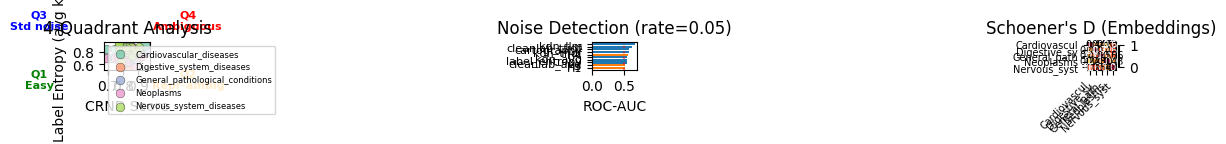


Total elapsed time: 31.1s


In [13]:
# --- Results Summary Table ---
print("=" * 70)
print("NOISE DETECTION RESULTS (ROC-AUC)")
print("=" * 70)

for rate_str, rate_results in noise_results.items():
    print(f"\nNoise rate: {rate_str}")
    print(f"{'Method':<20} {'ROC-AUC':>10} {'Spearman':>10} {'Prec@K':>10}")
    print("-" * 52)

    # Sort by ROC-AUC
    sorted_methods = sorted(
        rate_results.items(),
        key=lambda x: x[1].get("roc_auc_mean", 0),
        reverse=True,
    )
    for method_name, metrics in sorted_methods:
        auc = metrics.get("roc_auc_mean", 0)
        rho = metrics.get("spearman_rho_mean", 0)
        prec = metrics.get("precision_at_k_mean", 0)
        print(f"{method_name:<20} {auc:>10.4f} {rho:>10.4f} {prec:>10.4f}")

# --- Figure 1: CRND vs Label Entropy Scatter (4-Quadrant) ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: CRND vs Label Entropy quadrants
ax = axes[0]
med_c = quadrant_results["median_crnd"]
med_e = quadrant_results["median_label_entropy"]

colors_map = {c: plt.cm.Set2(i) for i, c in enumerate(le.classes_)}
for i, cls in enumerate(le.classes_):
    mask = labels_encoded == i
    ax.scatter(crnd[mask], label_entropy[mask], c=[colors_map[cls]], label=cls, alpha=0.7, s=40, edgecolors="k", linewidths=0.3)

ax.axvline(med_c, color="gray", linestyle="--", alpha=0.7, linewidth=1)
ax.axhline(med_e, color="gray", linestyle="--", alpha=0.7, linewidth=1)
ax.set_xlabel("CRND Score")
ax.set_ylabel("Label Entropy (avg kDN)")
ax.set_title("4-Quadrant Analysis")
ax.legend(fontsize=6, loc="upper left")

# Add quadrant labels
ax.text(med_c * 0.3, med_e * 0.3, "Q1\nEasy", ha="center", fontsize=8, color="green", weight="bold")
ax.text(med_c * 1.5, med_e * 0.3, "Q2\nRepr-ambig", ha="center", fontsize=8, color="orange", weight="bold")
ax.text(med_c * 0.3, med_e * 1.5, "Q3\nStd noise", ha="center", fontsize=8, color="blue", weight="bold")
ax.text(med_c * 1.5, med_e * 1.5, "Q4\nAmbiguous", ha="center", fontsize=8, color="red", weight="bold")

# Panel 2: ROC-AUC comparison bar chart
ax = axes[1]
if noise_results:
    first_rate = list(noise_results.keys())[0]
    rate_data = noise_results[first_rate]
    methods_sorted = sorted(rate_data.items(), key=lambda x: x[1].get("roc_auc_mean", 0), reverse=True)[:10]
    names = [m[0] for m in methods_sorted]
    aucs = [m[1].get("roc_auc_mean", 0) for m in methods_sorted]

    bars = ax.barh(range(len(names)), aucs, color=["#ff7f0e" if "H" in n else "#1f77b4" for n in names])
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names, fontsize=8)
    ax.set_xlabel("ROC-AUC")
    ax.set_title(f"Noise Detection (rate={first_rate})")
    ax.axvline(0.5, color="red", linestyle=":", alpha=0.5, label="Random baseline")
    ax.invert_yaxis()

# Panel 3: Niche overlap heatmap (embedding space)
ax = axes[2]
im = ax.imshow(niche_embed, cmap="YlOrRd", vmin=0, vmax=1)
ax.set_xticks(range(len(le.classes_)))
ax.set_yticks(range(len(le.classes_)))
ax.set_xticklabels([c[:12] for c in le.classes_], rotation=45, ha="right", fontsize=7)
ax.set_yticklabels([c[:12] for c in le.classes_], fontsize=7)
ax.set_title("Schoener's D (Embeddings)")
plt.colorbar(im, ax=ax, shrink=0.8)

# Add values in cells
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        val = niche_embed[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7,
                    color="white" if val > 0.6 else "black")

plt.tight_layout()
plt.savefig("crnd_results.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nTotal elapsed time: {time.time() - t_start:.1f}s")